In [1]:
from __future__ import print_function
import os
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten,\
                         Dropout,GlobalMaxPooling1D, Lambda, Concatenate, Dense, regularizers
from keras.utils import np_utils
from keras import backend as K
from keras import optimizers, activations

from keras import callbacks
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

from matplotlib import pyplot as plt
from IPython.display import clear_output
from scipy.misc import toimage
import pickle
os.environ["CUDA_VISIBLE_DEVICES"]="1"


config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)
print("Using GPU: ", K.tensorflow_backend._get_available_gpus())

K.set_image_dim_ordering('tf')

seed = 10
np.random.seed(seed)

Using TensorFlow backend.


Using GPU:  ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 355
batch_size = 128

In [3]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    
    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    print(labels_.shape)
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

In [5]:
file_name=('data_batch_1')
image_train, y_train=load_data(file_name)
image_test, y_test=load_data('test_batch')

(10000, 10)
(10000, 10)


The pixel values are in the range of 0 to 255 for each of the red, green and blue channels.
It is good practice to work with normalized data. Because the input values are well understood, we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation which is 255.

In [6]:
print(image_train.shape)


# print(test_dic.keys())


X_train = image_train / 255.0
X_test = image_test / 255.0

# Convert class vectors to binary class matrices.

print(y_train.shape)
# y_test = np_utils.to_categorical(y_test, num_classes)

(10000, 3072)
(10000, 10)


In [7]:
print(X_train.shape[0], 'train samples')
#print(X_test.shape[1], 'test samples')
# chans, # images, # rows, # cols)
X_train = X_train.reshape(X_train.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

print(X_train.shape)
print(X_test.shape)

10000 train samples
(10000, 3072)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [8]:
def cross_entropy(y_true, y_pred):
    foo =tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                         logits=y_pred)
    return tf.reduce_mean(foo)

In [9]:
class PlotLosses(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.legend()
        
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
#        plt.plot(self.x, self.val_losses, label="val_loss")
        
        plt.show();
        
plot_losses = PlotLosses()

In [10]:
def cnn(X_train, y_train,X_test, y_test,batch_size,epochs,NUM_CLASSES,
       IMG_SIZE, NUM_CHANNELS,learning_rate,con_size,kernel_size,
       con_size2,kernel_size2 ):
        model = Sequential()
        model.add(Conv2D(con_size, kernel_size=kernel_size,padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS), activation='relu',name='con1'))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=2 ,name='pool1'))
        model.add(Conv2D(con_size2,kernel_size=kernel_size2 ,padding='valid', activation='relu',name='con2'))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=2,name='pool2'))
        model.add(Flatten())
        model.add(Dense(300, activation='relu'))
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        #decay = lrate/epochs
        sgd =  optimizers.SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
        print(model.summary())

        history=model.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=epochs, batch_size=batch_size,callbacks=[plot_losses])
        # Final evaluation of the model

        score_test = model.evaluate(X_test, y_test, verbose=0)
        print('Test accuracy:', score_test[1])
        return  model, score_test[1], history


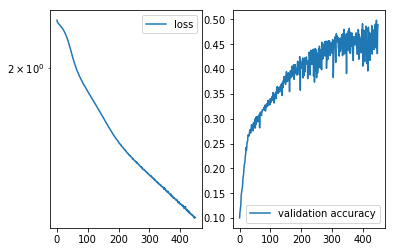

10000/10000 [==============================] - 1s 106us/step - loss: 1.2686 - acc: 0.5625 - val_loss: 1.4274 - val_acc: 0.4891
Test accuracy: 0.4891


In [11]:
con_size= 32 
kernel_size=2 
con_size2=128 
kernel_size2= 3 
epochs=450

model, test_accuracy,history= cnn(X_train, y_train,X_test, y_test,batch_size,epochs,NUM_CLASSES,
                    IMG_SIZE, NUM_CHANNELS,learning_rate,con_size,kernel_size,con_size2,kernel_size2)

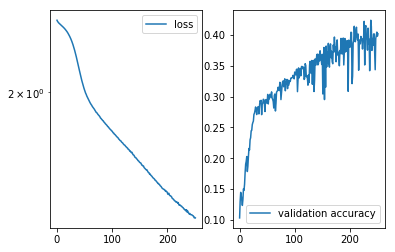

10000/10000 [==============================] - 2s 190us/step - loss: 1.5617 - acc: 0.4530 - val_loss: 1.6786 - val_acc: 0.4019
Epoch 253/500
  640/10000 [>.............................] - ETA: 1s - loss: 1.6144 - acc: 0.4156

In [ ]:
max_acc=0
model_par=[]
CON_SIZE=[32,64,128] 
CON_SIZE2=[32,64,128]
KERNAL_SIZE=[2,3,5]
KERNAL_SIZE2=[2,3,5]
EPOCHS=[100,200,500]

for con_size in CON_SIZE:
    for kernel_size in KERNAL_SIZE:
        for con_size2 in CON_SIZE2:
            for kernel_size2 in KERNAL_SIZE2:
                for epochs in EPOCHS:
                    
                    test_accuracy,model= cnn(X_train, y_train,X_test, y_test,batch_size,epochs,NUM_CLASSES,
                    IMG_SIZE, NUM_CHANNELS,learning_rate,con_size,kernel_size,con_size2,kernel_size2)
                    if max_acc < test_accuracy:
                        max_model=model
                        max_acc=test_accuracy
                        model_par.append('test_accuracy: '+str(test_accuracy)+' CON_SIZE: '+str(con_size)+' kernel_size:'+str(kernel_size)
                                        +' CON_SIZE2:'+str(con_size2)+' kernel_size2: '+str(kernel_size2)+ ' epochs:'+str(epochs))


## Plot test accuracy  &&  training loss over   epochs

In [21]:
print(model_par)

['test_accuracy: 0.3421 CON_SIZE: 32 kernel_size:2 CON_SIZE2:32 kernel_size2: 2 epochs:100', 'test_accuracy: 0.4121 CON_SIZE: 32 kernel_size:2 CON_SIZE2:32 kernel_size2: 2 epochs:200', 'test_accuracy: 0.4725 CON_SIZE: 32 kernel_size:2 CON_SIZE2:32 kernel_size2: 2 epochs:500', 'test_accuracy: 0.4766 CON_SIZE: 32 kernel_size:2 CON_SIZE2:32 kernel_size2: 3 epochs:500', 'test_accuracy: 0.4816 CON_SIZE: 32 kernel_size:2 CON_SIZE2:64 kernel_size2: 5 epochs:500', 'test_accuracy: 0.5032 CON_SIZE: 32 kernel_size:2 CON_SIZE2:128 kernel_size2: 3 epochs:500']


In [46]:
con_layers = [ layer.name for layer in model.layers]
print(con_layers)

['con1', 'pool1', 'con2', 'pool2', 'flatten_339', 'dense_677', 'dense_678']


In [31]:
pool1_extractor = Model(inputs=model.input, outputs=model.get_layer('con1').output)
X = X_test[1,:]
X=np.asarray(X)

#X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

pool1_featres = pool1_extractor.predict(X)
print(pool1_featres.shape)
# so we gate a numpy array, with 256 features maps, of size 28x28, for 1 element.
#plt.imshow(pool1_featres[0, :, :, 0], cmap='gray')
#plt.show()

(1, 31, 31, 32)


In [28]:
def plot_feature_maps(feature_maps,layer_name):
    height, width, depth = feature_maps.shape
    nb_plot = int(np.rint(np.sqrt(depth)))
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(depth-7):
        plt.axis('off')
        plt.subplot(nb_plot, nb_plot, i+1)
        plt.imshow(feature_maps[:,:,i],cmap='gray')
        #plt.title('feature map {}'.format(i+1))
#    plt.savefig('./p1b_2_pool2.png')
    plt.savefig('./p1_2_'+layer_name+'.png')
    plt.show()
    
#plot_feature_maps(pool1_featres[0])


At layer "con1" : (31, 31, 32) 


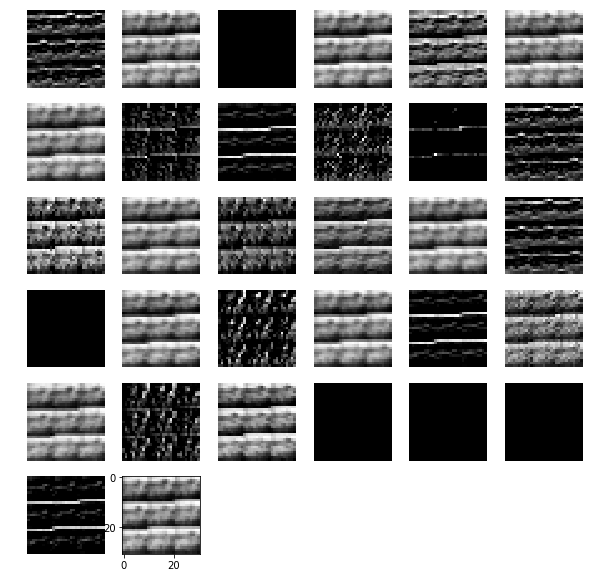

In [26]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
    
plot_layer('con1')

At layer "con2" : (13, 13, 128) 


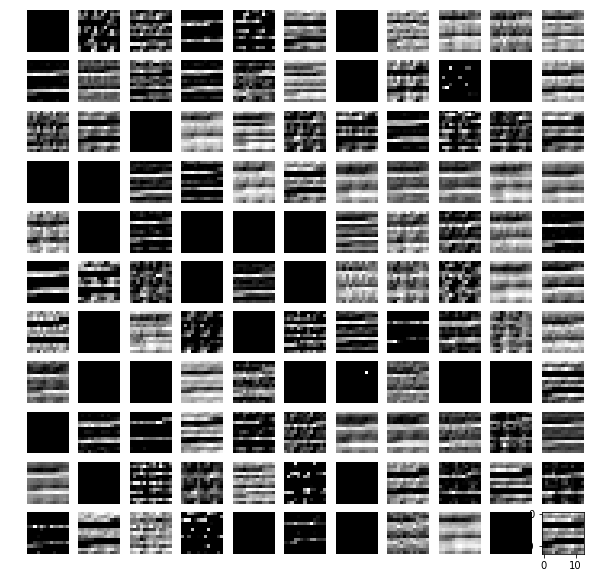

In [29]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
plot_layer('con2')

At layer "pool1" : (15, 15, 32) 


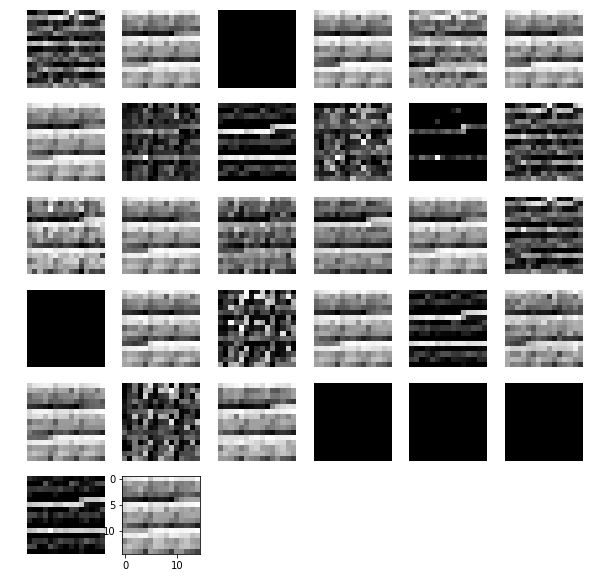

In [27]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
plot_layer('pool1')

At layer "pool2" : (6, 6, 128) 


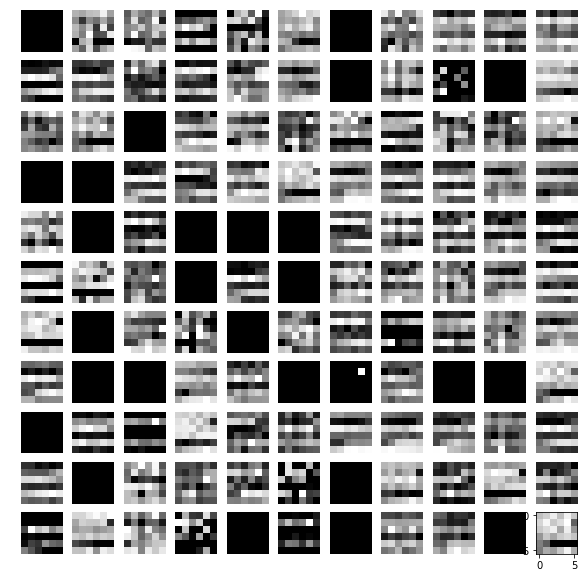

In [30]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
plot_layer('pool2')

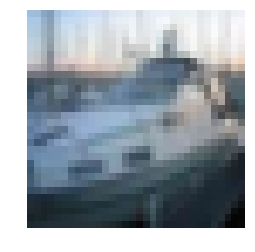

In [70]:
X = X_test[2,:]
X_test_new = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
plt.imshow(X_test_new[:,:])
plt.axis('off')
plt.savefig('./p1b_2_patterns.png')
plt.show()


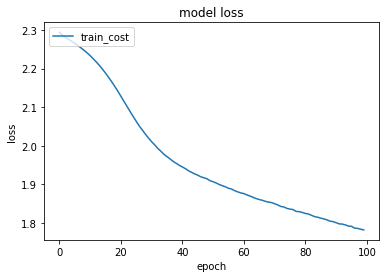

In [77]:
#training cost 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_cost'], loc='upper left')
plt.savefig('./p1a_train_cost_.png')
plt.show()


In [26]:
# summarize history for accuracy
# test accuracy 
#plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test_acc'], loc='upper left')
plt.savefig('./p1a_test_acc_.png')
plt.show()
# summarize history for loss

NameError: name 'history' is not defined

In [129]:
def feature_map(model):
    ind = np.random.randint(low=0, high=10000)
    X = X_test[ind,:]
#    X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
    X_show=X.reshape(X.shape[0] ,IMG_SIZE, IMG_SIZE,NUM_CHANNELS)

    con_image=model.predict(X_show)
    con_image=np.squeeze(con_image, axis=0)
    plt.axis('off')
    plt.imshow(con_image)    
    plt.figure()
    plt.gray()
    plt.show()

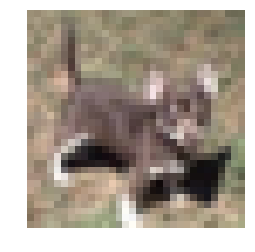

<Figure size 432x288 with 0 Axes>

In [26]:
#ind = np.random.randint(low=0, high=10000)
X = X_test[ind,:]
X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
plt.axis('off')
plt.imshow(X_show)    
plt.figure()
plt.gray()
plt.show()